# Homework 3: Mining Data Stream
## Authors: Fabio Camerota, Gianluca Ruberto

## Solution
The goal of this project is to implement TRIEST BASE and TRIEST IMPR algorithms presented in the paper L. De Stefani, A. Epasto, M. Riondato, and E. Upfal, [TRIÈST: Counting Local and Global Triangles in Fully-Dynamic Streams with Fixed Memory Size, KDD'16](https://www.kdd.org/kdd2016/papers/files/rfp0465-de-stefaniA.pdf).

## Dataset
The dataset used is [Social Circles: Facebook](https://snap.stanford.edu/data/ego-Facebook.html) from Stanford University.

In [1]:
true_triangles= 1612010 # provided from the source

## Import libraries

In [2]:
import random
import time
import matplotlib.pyplot as plt

## Load Data

In [3]:
datContent = [i.strip().split() for i in open("facebook_combined.txt").readlines()]
streamData = []
for i in range(0,len(datContent)):#the first element is not useful
    value = datContent[i]
    streamData.append(tuple([int(value[0]),int(value[1])]))
streamData

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (0, 26),
 (0, 27),
 (0, 28),
 (0, 29),
 (0, 30),
 (0, 31),
 (0, 32),
 (0, 33),
 (0, 34),
 (0, 35),
 (0, 36),
 (0, 37),
 (0, 38),
 (0, 39),
 (0, 40),
 (0, 41),
 (0, 42),
 (0, 43),
 (0, 44),
 (0, 45),
 (0, 46),
 (0, 47),
 (0, 48),
 (0, 49),
 (0, 50),
 (0, 51),
 (0, 52),
 (0, 53),
 (0, 54),
 (0, 55),
 (0, 56),
 (0, 57),
 (0, 58),
 (0, 59),
 (0, 60),
 (0, 61),
 (0, 62),
 (0, 63),
 (0, 64),
 (0, 65),
 (0, 66),
 (0, 67),
 (0, 68),
 (0, 69),
 (0, 70),
 (0, 71),
 (0, 72),
 (0, 73),
 (0, 74),
 (0, 75),
 (0, 76),
 (0, 77),
 (0, 78),
 (0, 79),
 (0, 80),
 (0, 81),
 (0, 82),
 (0, 83),
 (0, 84),
 (0, 85),
 (0, 86),
 (0, 87),
 (0, 88),
 (0, 89),
 (0, 90),
 (0, 91),
 (0, 92),
 (0, 93),
 (0, 94),
 (0, 95),
 (0, 96),
 (0, 97),
 (0, 98),
 (0, 99),
 (0, 100),
 (0, 101

## Triest BASE

In [4]:
class TRIEST_BASE:
    def __init__(self,m):
        if(m<6):
            raise Exception('M must be at least 6')
        self.S = set()
        self.m = m
        self.t = 0
        self.tau=0 #total number of triangles
        self.counters = dict()
        
    def sampleEdge(self,edge): #reservoir sampling
        if(self.t<=self.m):
            return True
        elif(random.uniform(0,1) <= self.m/self.t):
            to_remove = random.sample(self.S,1)[0] #remove random element from a set
            self.S.remove(to_remove)
            self.updateCounters('-',to_remove)
            return True
        else:
            return False  
        
    def updateCounters(self, sign, edge):
        Nu= set()
        Nv= set()
        # creating the neighbours considering the incoming and outcoming edges
        for el in self.S:
            if(el[0]==edge[0]): #adding vertices reached from the first element of the edge
                Nu.add(el[1])
            if(el[1]==edge[0]): #adding vertices that reach the first element of the edge
                Nu.add(el[0])
            if(el[0]==edge[1]): #adding vertices reached from the second element of the edge
                Nv.add(el[1])
            if(el[1]==edge[1]): #adding vertices that reach the second element of the edge
                Nv.add(el[0])
                
        #updating counters    
        for vertex in (Nu & Nv):
            if(sign=='+'):
                self.tau+=1
                self.counters[vertex] = self.counters.get(vertex, 0) + 1
                self.counters[edge[0]] = self.counters.get(edge[0], 0) + 1
                self.counters[edge[1]] = self.counters.get(edge[1], 0) + 1
            else:
                self.tau-=1
                self.counters[vertex] = self.counters.get(vertex, 0) - 1
                self.counters[edge[0]] = self.counters.get(edge[0], 0) - 1
                self.counters[edge[1]] = self.counters.get(edge[1], 0) - 1
                #The local counters are always destroyed as soon as they have a value of 0
                if self.counters[vertex] <= 0:
                    del self.counters[vertex]
                if self.counters[edge[0]] <= 0:    
                    del self.counters[edge[0]]
                if self.counters[edge[1]] <= 0:  
                    del self.counters[edge[1]]
                
    def run(self,streamData):
        for edge in streamData:
            self.t+=1
            if self.sampleEdge(edge):
                self.S.add(edge)
                self.updateCounters('+',edge)
        estimation = max(1, (self.t*(self.t-1)*(self.t-2))/(self.m*(self.m-1)*(self.m-2)))
        return self.tau * estimation

## TRIEST IMPR
Trièst-impr is a variant of trièst-base that result in lower variance estimations.

In [5]:
class TRIEST_IMPR:
    def __init__(self,m):
        if(m<6):
            raise Exception('M must be at least 6')
        self.S = set()
        self.m = m
        self.t = 0
        self.tau=0 #total number of triangles
        self.counters = dict()
        
    def sampleEdge(self,edge):  #reservoir sampling
        if(self.t<=self.m):
            return True
        elif(random.uniform(0,1) <= self.m/self.t):
            to_remove = random.sample(self.S,1)[0] #remove random element from a set
            self.S.remove(to_remove)
#             self.updateCounters('-',to_remove) removed
            return True
        else:
            return False  
        
    def updateCounters(self, edge): #removed the operation from the signature
        Nu= set()
        Nv= set()
        # creating the neighbours considering the incoming and outcoming edges
        for el in self.S:
            if(el[0]==edge[0]): #adding vertices reached from the first element of the edge
                Nu.add(el[1])
            if(el[1]==edge[0]): #adding vertices that reach the first element of the edge
                Nu.add(el[0])
            if(el[0]==edge[1]): #adding vertices reached from the second element of the edge
                Nv.add(el[1])
            if(el[1]==edge[1]): #adding vertices that reach the second element of the edge
                Nv.add(el[0])
                
        #updating counters
       
        eta = max(1, ((self.t-1)*(self.t-2))/(self.m*(self.m-1)))  #added
        for vertex in (Nu & Nv):
            self.tau+=eta
            self.counters[vertex] = self.counters.get(vertex, 0) + eta
            self.counters[edge[0]] = self.counters.get(edge[0], 0) + eta
            self.counters[edge[1]] = self.counters.get(edge[1], 0) + eta
           
    def run(self,streamData):
        for edge in streamData:
            self.t+=1
            self.updateCounters(edge) #moved here and removed operation
            if self.sampleEdge(edge):
                self.S.add(edge)
        estimation = max(1, (self.t*(self.t-1)*(self.t-2))/(self.m*(self.m-1)*(self.m-2)))
        return self.tau #* estimation removed

## Computation

### TRIEST BASE

In [6]:
TRIEST_triangles = TRIEST_BASE(5000).run(streamData)
print("Total number of triangles: "+str(TRIEST_triangles))

C:\Users\gianl\AppData\Local\Temp\ipykernel_2296\1752265797.py:15: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  to_remove = random.sample(self.S,1)[0] #remove random element from a set


Total number of triangles: 1534079.7878593886


In [7]:
print("Absolute Percentage Error = " + str(abs((TRIEST_triangles-true_triangles)/true_triangles *100)) + "%")

Absolute Percentage Error = 4.834350415978274%


### TRIEST IMPR

In [8]:
TRIEST_IMPR_triangles = TRIEST_IMPR(5000).run(streamData)
print("Total number of triangles: "+str(TRIEST_IMPR_triangles))

C:\Users\gianl\AppData\Local\Temp\ipykernel_2296\509614654.py:15: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  to_remove = random.sample(self.S,1)[0] #remove random element from a set


Total number of triangles: 1712282.2394734104


In [9]:
print("Absolute Percentage Error = " + str(abs((TRIEST_IMPR_triangles-true_triangles)/true_triangles *100)) + "%")

Absolute Percentage Error = 6.220323662595791%


## Visualization

### Computing the results

In [10]:
m_list = [1000, 5000, 10000]
base_times = []
base_MAPE = []
iterations = 3
for m in m_list:
    times = []
    ape = []
    for i in range(iterations):
        start = time.time()
        triangles = TRIEST_BASE(m).run(streamData)
        duration = time.time() -start
        times.append(duration)
        ape.append(abs((triangles-true_triangles)/true_triangles *100))
    base_times.append(sum(times)/len(times))
    base_MAPE.append(sum(ape)/len(ape))

C:\Users\gianl\AppData\Local\Temp\ipykernel_2296\1752265797.py:15: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  to_remove = random.sample(self.S,1)[0] #remove random element from a set


In [11]:
impr_times = []
impr_MAPE = []
for m in m_list:
    times = []
    ape = []
    for i in range(iterations):
        start = time.time()
        triangles = TRIEST_IMPR(m).run(streamData)
        duration = time.time() -start
        times.append(duration)
        ape.append(abs((triangles-true_triangles)/true_triangles *100))
    impr_times.append(sum(times)/len(times))
    impr_MAPE.append(sum(ape)/len(ape))

C:\Users\gianl\AppData\Local\Temp\ipykernel_2296\509614654.py:15: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  to_remove = random.sample(self.S,1)[0] #remove random element from a set


### TRIEST BASE

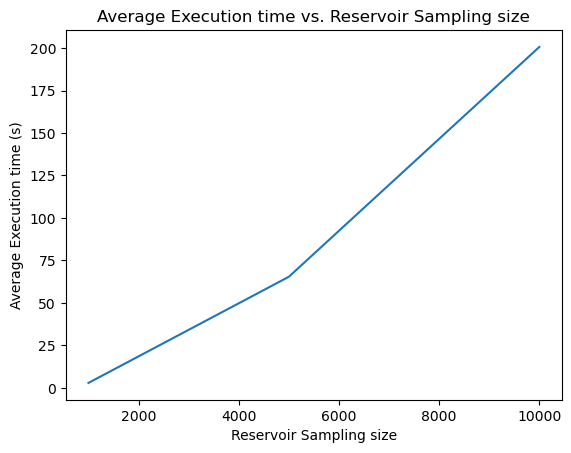

In [12]:
plt.plot(m_list, base_times)
plt.xlabel('Reservoir Sampling size')
plt.ylabel('Average Execution time (s)')
plt.title('Average Execution time vs. Reservoir Sampling size')
plt.show()

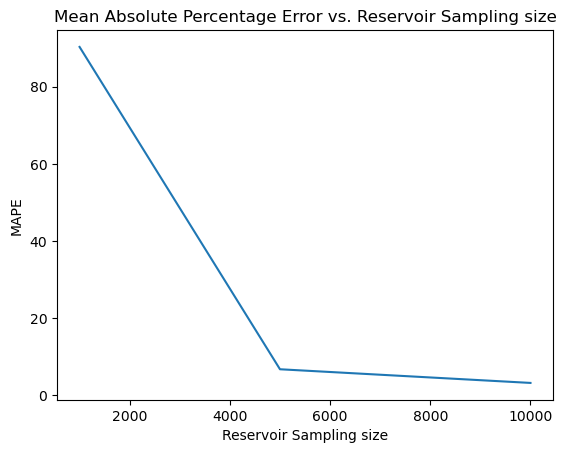

In [13]:
plt.plot(m_list, base_MAPE)
plt.xlabel('Reservoir Sampling size')
plt.ylabel('MAPE')
plt.title('Mean Absolute Percentage Error vs. Reservoir Sampling size')
plt.show()

### TRIEST IMPR

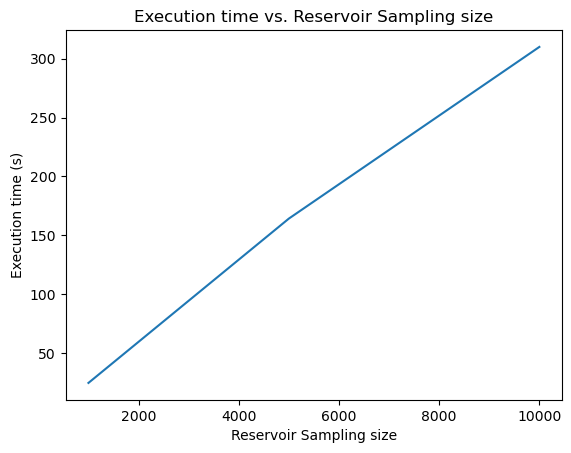

In [14]:
plt.plot(m_list, impr_times)
plt.xlabel('Reservoir Sampling size')
plt.ylabel('Execution time (s)')
plt.title('Execution time vs. Reservoir Sampling size')
plt.show()

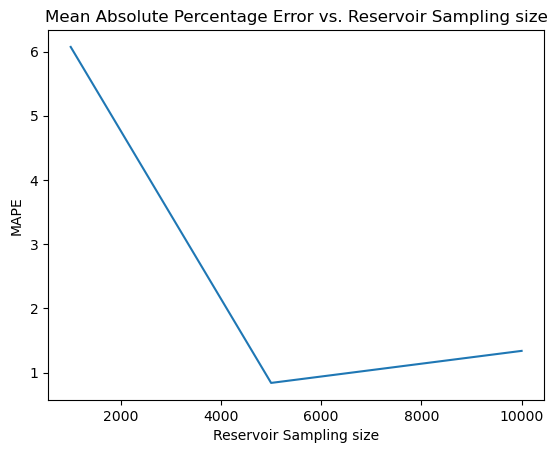

In [15]:
plt.plot(m_list, impr_MAPE)
plt.xlabel('Reservoir Sampling size')
plt.ylabel('MAPE')
plt.title('Mean Absolute Percentage Error vs. Reservoir Sampling size')
plt.show()

## Questions

#### 1. What were the challenges you faced when implementing the algorithm?
The most difficult part was understanding how to compute the neighbours of a vertex efficiently. Moreover, we needed to find a dataset with the right properties to apply the algorithm. In particular we needed an undirected graph.

#### 2. Can the algorithm be easily parallelized? If yes, how? If not, why? Explain.
The algorithm could be parallelized by adding sinchronization on updateCounters function and when you read elements from the stream. However, there will not be any improvement in performance since it is not possible to update the counters in parallel.

#### 3. Does the algorithm work for unbounded graph streams? Explain.
Yes, the algorithm works for unbounded graph streams. At each iteration t, it keeps the estimate of the number of triangles up to that moment

#### 4. Does the algorithm support edge deletions? If not, what modification would it need? Explain.
The algorithms TRIÈST-BASE and TRIÈST-IMPR do not support edge deletions. However the authors of the paper proposed TRIÈST-FD that works also in this case. TRIÈST-FD (fully dynamic version) uses Random Pairing that is an extension of
reservoir sampling to handle fully-dynamic streams with insertions and deletions. The idea behind Random Pairing is that edge deletions seen on the stream will be “compensated” by future edge insertions. So there's a counter that
keeps track of the number of uncompensated edge deletions and based on this new edges are inserted in the sample set S and the total number of triangles are estimated.